In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# R2 값, 결정계수 계산
from sklearn.metrics import r2_score

# OLS회귀분석
import statsmodels.api as sm

# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor



# 시각화
import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
from pylab import rcParams

font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# from matplotlib import rcParams
# rcParams['font.family'] = 'NanumGothicCoding'

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1)).astype('int64')
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula
#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
# w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul_category.csv', parse_dates=['date'], index_col=0)
w = pd.read_csv('d:/project/contest/data/processed/날씨_ver071915.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '생수'만 빼서 df생성
item = '생수'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow','rain_or_not','snow_or_not','미세', '초미세', '공기상태',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

In [5]:
# MAD적용
gs_day_w['outlier'] = pd.DataFrame(mad_based_outlier(gs_day_w['qty']))
gs_day_w = gs_day_w.loc[gs_day_w.outlier==False]

In [6]:
# list_col = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10'] # +,'rain_or_not','snow_or_not'
list_col = ['temp', 'cloud', 'wind','lgt_time',
            'rain_or_not', 'snow_or_not', '공기상태'] #+'rain_or_not', 'snow_or_not'
lowVIF(w,20,list_col)

,VIF_Factor,features
0,1.239620,snow_or_not
1,2.479988,rain_or_not
2,3.114369,공기상태
3,4.013218,temp
4,6.725926,cloud
5,8.084050,lgt_time
6,9.334878,wind


In [7]:
train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# 날씨 데이터만
combined = gs_day_w.loc[:,list_col]
target = gs_day_w.loc[:,'qty']
Xy = pd.concat([target,combined], axis=1)

In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('수치형 자료 컬럼 갯수 :',len(num_cols))
print ('오브젝트형 자료 컬럼 갯수 :',len(cat_cols))

수치형 자료 컬럼 갯수 : 7
오브젝트형 자료 컬럼 갯수 : 0


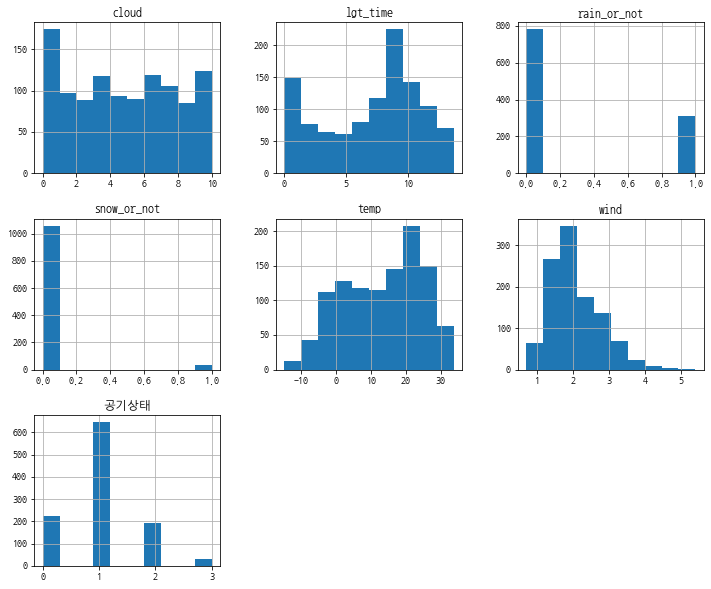

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

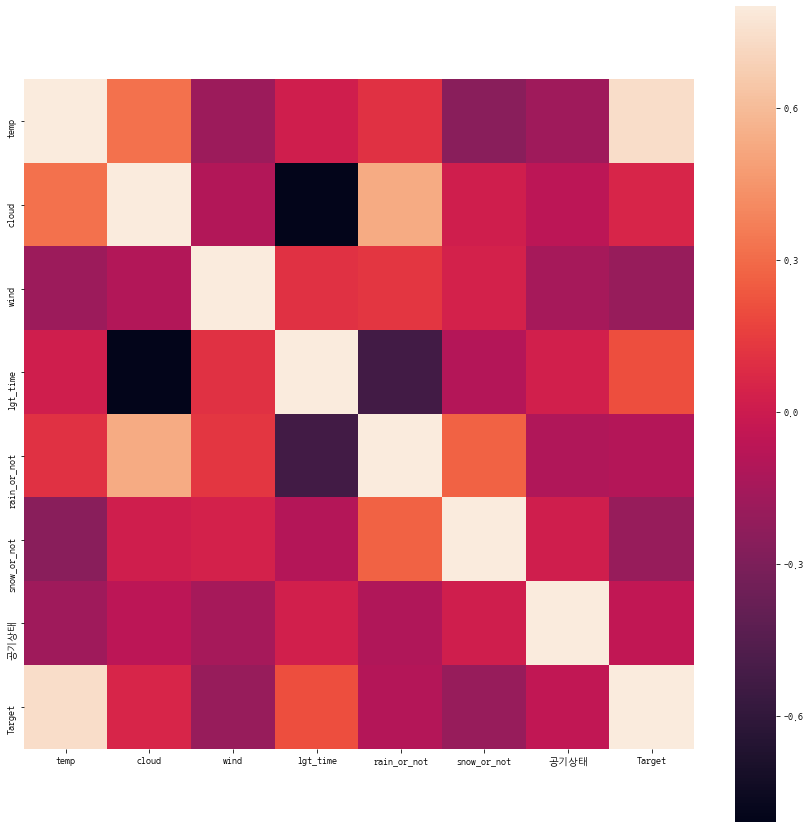

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        # 해당 컬럼의 데이터 타입이 object란 소리는 숫자가 아니다 = 분류형 데이터
        if( df[col].dtype == np.dtype('object')):
            # 더미 컬럼 생성
            dummies = pd.get_dummies(df[col],prefix=col)
            # 원본 데이터에 이어 붙이기 axis=1 컬럼방향으로 
            df = pd.concat([df,dummies],axis=1)

            # 기존의 str형 컬럼 삭제
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('분류형(category형) 컬럼 수정 전, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
#### 내가 '공기상태'라는 컬럼이 사실은 category형이라는것을 알기에 직접 dummy컬럼 생성
airCondition_dummies = pd.get_dummies(combined['공기상태'],prefix='공기상태')
combined = pd.concat([combined, airCondition_dummies], axis=1)
combined.drop(['공기상태'],axis = 1 , inplace=True)
######################################################################################
print('분류형(category형) 컬럼 수정 후, 총 {} 개의 columns이 있었습니다.'.format(combined.shape[1]))

분류형(category형) 컬럼 수정 전, 총 7 개의 columns이 있었습니다.
분류형(category형) 컬럼 수정 후, 총 10 개의 columns이 있었습니다.


In [13]:
# 공기상태_0,공기상태_1,공기상태_2가 전부 0이면,   공기상태_3이 1이란 소리고
#                                                               공기상태가 '매우나쁨' 임을 추정할수 있다.
# 그런이유로 공기상태_3삭제
combined.drop(['공기상태_3'],axis = 1 , inplace=True)

In [14]:
Xy = pd.concat([target,combined], axis=1)
# Xy.head(1)

In [15]:
# 첫 2년 : 732 일
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 9)

In [16]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# optimizer에 여러 방식이 있다.
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0722 15:01:43.373773  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 15:01:43.393720  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 15:01:43.397709  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0722 15:01:43.487470  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 인공 신경망에 의해 생성된 weight 자료를 저장하기 위해서
checkpoint_name = item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}-cat02-vf05.hdf5'

# save_best_only값이 저장되어, 모든 weight값을 저장하지 않고, val_loss값이 줄어들때마다(적을수록 좋다.) 저장
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [20]:
# 예제에서는 target을 대회에서 주는 target데이터를 기준으로 미리 train데이터와 맞춰졌있지만
# gs/lv데이터는 아니다. 그래서 위에서 나누는 기준으로 삼은cut_line=732을 이용하여 데이터 사이즈를 맞춰준다.
# 아니면 애시당초에(맨처음에) 훈련용 데이터와 타겟을 만들어 놓는것도 좋다.
NN_model.fit(train, target[:cut_line], epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0722 14:31:57.750377 12212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0722 14:31:57.858092 12212 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/1000
585/585 [==============================] - 0s 509us/step - loss: 10281.7163 - mean_absolute_error: 10281.7163 - val_loss: 9027.8383 - val_mean_absolute_error: 9027.8383

Epoch 00001: val_loss improved from inf to 9027.83831, saving model to 생수date-Weights-001--9027.83831-cat02-vf05.hdf5
Epoch 2/1000
585/585 [==============================] - 0s 77us/step - loss: 9742.2337 - mean_absolute_error: 9742.2337 - val_loss: 7036.3033 - val_mean_absolute_error: 7036.3033

Epoch 00002: val_loss improved from 9027.83831 to 7036.30331, saving model to 생수date-Weights-002--7036.30331-cat02-vf05.hdf5
Epoch 3/1000
585/585 [==============================] - 0s 87us/step - loss: 4433.4279 - mean_absolute_error: 4433.4279 - val_loss: 2394.3706 - val_mean_absolute_error: 2394.3706

Epoch 00003: val_loss improved from 7036.30331 to 2394.37065, saving model to 생수date-Weights-003--2394.37065-cat02-vf05.hdf5
Epoch 4/1000
585/585 [=====================

585/585 [==============================] - 0s 95us/step - loss: 1410.1394 - mean_absolute_error: 1410.1394 - val_loss: 1173.4809 - val_mean_absolute_error: 1173.4809

Epoch 00064: val_loss improved from 1221.37694 to 1173.48089, saving model to 생수date-Weights-064--1173.48089-cat02-vf05.hdf5
Epoch 65/1000
585/585 [==============================] - 0s 89us/step - loss: 1369.7307 - mean_absolute_error: 1369.7307 - val_loss: 1279.9483 - val_mean_absolute_error: 1279.9483

Epoch 00065: val_loss did not improve from 1173.48089
Epoch 66/1000
585/585 [==============================] - 0s 89us/step - loss: 1369.2534 - mean_absolute_error: 1369.2534 - val_loss: 1206.2837 - val_mean_absolute_error: 1206.2837

Epoch 00066: val_loss did not improve from 1173.48089
Epoch 67/1000
585/585 [==============================] - 0s 95us/step - loss: 1378.8917 - mean_absolute_error: 1378.8917 - val_loss: 1277.6556 - val_mean_absolute_error: 1277.6556

Epoch 00067: val_loss did not improve from 1173.48089
Epo

585/585 [==============================] - 0s 140us/step - loss: 1327.3747 - mean_absolute_error: 1327.3747 - val_loss: 1382.4268 - val_mean_absolute_error: 1382.4268

Epoch 00132: val_loss did not improve from 1143.92794
Epoch 133/1000
585/585 [==============================] - 0s 147us/step - loss: 1299.3549 - mean_absolute_error: 1299.3549 - val_loss: 1148.2519 - val_mean_absolute_error: 1148.2519

Epoch 00133: val_loss did not improve from 1143.92794
Epoch 134/1000
585/585 [==============================] - 0s 130us/step - loss: 1552.4330 - mean_absolute_error: 1552.4330 - val_loss: 1132.2717 - val_mean_absolute_error: 1132.2717

Epoch 00134: val_loss improved from 1143.92794 to 1132.27175, saving model to 생수date-Weights-134--1132.27175-cat02-vf05.hdf5
Epoch 135/1000
585/585 [==============================] - 0s 114us/step - loss: 1377.9729 - mean_absolute_error: 1377.9729 - val_loss: 1452.0831 - val_mean_absolute_error: 1452.0831

Epoch 00135: val_loss did not improve from 1132.27

585/585 [==============================] - 0s 143us/step - loss: 1277.0077 - mean_absolute_error: 1277.0077 - val_loss: 1417.2039 - val_mean_absolute_error: 1417.2039

Epoch 00166: val_loss did not improve from 1124.26647
Epoch 167/1000
585/585 [==============================] - 0s 138us/step - loss: 1324.1417 - mean_absolute_error: 1324.1417 - val_loss: 1362.9638 - val_mean_absolute_error: 1362.9638

Epoch 00167: val_loss did not improve from 1124.26647
Epoch 168/1000
585/585 [==============================] - 0s 131us/step - loss: 1272.2993 - mean_absolute_error: 1272.2993 - val_loss: 1300.3604 - val_mean_absolute_error: 1300.3604

Epoch 00168: val_loss did not improve from 1124.26647
Epoch 169/1000
585/585 [==============================] - 0s 136us/step - loss: 1282.7756 - mean_absolute_error: 1282.7756 - val_loss: 1305.5229 - val_mean_absolute_error: 1305.5229

Epoch 00169: val_loss did not improve from 1124.26647
Epoch 170/1000
585/585 [==============================] - 0s 148us/


Epoch 00200: val_loss did not improve from 1124.26647
Epoch 201/1000
585/585 [==============================] - 0s 186us/step - loss: 1261.1078 - mean_absolute_error: 1261.1078 - val_loss: 1335.8387 - val_mean_absolute_error: 1335.8387

Epoch 00201: val_loss did not improve from 1124.26647
Epoch 202/1000
585/585 [==============================] - 0s 157us/step - loss: 1337.4417 - mean_absolute_error: 1337.4417 - val_loss: 1499.8892 - val_mean_absolute_error: 1499.8892

Epoch 00202: val_loss did not improve from 1124.26647
Epoch 203/1000
585/585 [==============================] - 0s 155us/step - loss: 1261.9895 - mean_absolute_error: 1261.9895 - val_loss: 1446.4114 - val_mean_absolute_error: 1446.4114

Epoch 00203: val_loss did not improve from 1124.26647
Epoch 204/1000
585/585 [==============================] - 0s 162us/step - loss: 1275.2864 - mean_absolute_error: 1275.2864 - val_loss: 1528.1053 - val_mean_absolute_error: 1528.1053

Epoch 00204: val_loss did not improve from 1124.266


Epoch 00269: val_loss did not improve from 1124.26647
Epoch 270/1000
585/585 [==============================] - 0s 232us/step - loss: 1202.7425 - mean_absolute_error: 1202.7425 - val_loss: 1386.7286 - val_mean_absolute_error: 1386.7286

Epoch 00270: val_loss did not improve from 1124.26647
Epoch 271/1000
585/585 [==============================] - 0s 208us/step - loss: 1196.7488 - mean_absolute_error: 1196.7488 - val_loss: 1675.1011 - val_mean_absolute_error: 1675.1011

Epoch 00271: val_loss did not improve from 1124.26647
Epoch 272/1000
585/585 [==============================] - 0s 220us/step - loss: 1222.0833 - mean_absolute_error: 1222.0833 - val_loss: 1383.1742 - val_mean_absolute_error: 1383.1742

Epoch 00272: val_loss did not improve from 1124.26647
Epoch 273/1000
585/585 [==============================] - 0s 297us/step - loss: 1231.7242 - mean_absolute_error: 1231.7242 - val_loss: 1628.6958 - val_mean_absolute_error: 1628.6958

Epoch 00273: val_loss did not improve from 1124.266


Epoch 00338: val_loss did not improve from 1124.26647
Epoch 339/1000
585/585 [==============================] - 0s 292us/step - loss: 1204.0099 - mean_absolute_error: 1204.0099 - val_loss: 1571.5324 - val_mean_absolute_error: 1571.5324

Epoch 00339: val_loss did not improve from 1124.26647
Epoch 340/1000
585/585 [==============================] - 0s 303us/step - loss: 1186.1300 - mean_absolute_error: 1186.1300 - val_loss: 1697.7157 - val_mean_absolute_error: 1697.7157

Epoch 00340: val_loss did not improve from 1124.26647
Epoch 341/1000
585/585 [==============================] - 0s 302us/step - loss: 1182.9382 - mean_absolute_error: 1182.9382 - val_loss: 1449.2655 - val_mean_absolute_error: 1449.2655

Epoch 00341: val_loss did not improve from 1124.26647
Epoch 342/1000
585/585 [==============================] - 0s 288us/step - loss: 1195.5067 - mean_absolute_error: 1195.5067 - val_loss: 1249.5027 - val_mean_absolute_error: 1249.5027

Epoch 00342: val_loss did not improve from 1124.266


Epoch 00407: val_loss did not improve from 1124.26647
Epoch 408/1000
585/585 [==============================] - 0s 174us/step - loss: 1178.4151 - mean_absolute_error: 1178.4151 - val_loss: 1295.4614 - val_mean_absolute_error: 1295.4614

Epoch 00408: val_loss did not improve from 1124.26647
Epoch 409/1000
585/585 [==============================] - 0s 184us/step - loss: 1174.1142 - mean_absolute_error: 1174.1142 - val_loss: 1691.5253 - val_mean_absolute_error: 1691.5253

Epoch 00409: val_loss did not improve from 1124.26647
Epoch 410/1000
585/585 [==============================] - 0s 167us/step - loss: 1266.7482 - mean_absolute_error: 1266.7482 - val_loss: 1490.5186 - val_mean_absolute_error: 1490.5186

Epoch 00410: val_loss did not improve from 1124.26647
Epoch 411/1000
585/585 [==============================] - 0s 159us/step - loss: 1180.5275 - mean_absolute_error: 1180.5275 - val_loss: 1564.2858 - val_mean_absolute_error: 1564.2858

Epoch 00411: val_loss did not improve from 1124.266


Epoch 00476: val_loss did not improve from 1124.26647
Epoch 477/1000
585/585 [==============================] - 0s 167us/step - loss: 1126.1399 - mean_absolute_error: 1126.1399 - val_loss: 1580.7112 - val_mean_absolute_error: 1580.7112

Epoch 00477: val_loss did not improve from 1124.26647
Epoch 478/1000
585/585 [==============================] - 0s 160us/step - loss: 1120.7836 - mean_absolute_error: 1120.7836 - val_loss: 1495.0355 - val_mean_absolute_error: 1495.0355

Epoch 00478: val_loss did not improve from 1124.26647
Epoch 479/1000
585/585 [==============================] - 0s 184us/step - loss: 1127.0794 - mean_absolute_error: 1127.0794 - val_loss: 1732.1166 - val_mean_absolute_error: 1732.1166

Epoch 00479: val_loss did not improve from 1124.26647
Epoch 480/1000
585/585 [==============================] - 0s 167us/step - loss: 1110.9042 - mean_absolute_error: 1110.9042 - val_loss: 1594.2604 - val_mean_absolute_error: 1594.2604

Epoch 00480: val_loss did not improve from 1124.266


Epoch 00545: val_loss did not improve from 1124.26647
Epoch 546/1000
585/585 [==============================] - 0s 153us/step - loss: 1154.4801 - mean_absolute_error: 1154.4801 - val_loss: 1717.5675 - val_mean_absolute_error: 1717.5675

Epoch 00546: val_loss did not improve from 1124.26647
Epoch 547/1000
585/585 [==============================] - 0s 153us/step - loss: 1115.1349 - mean_absolute_error: 1115.1349 - val_loss: 1392.2514 - val_mean_absolute_error: 1392.2514

Epoch 00547: val_loss did not improve from 1124.26647
Epoch 548/1000
585/585 [==============================] - 0s 164us/step - loss: 1171.8811 - mean_absolute_error: 1171.8811 - val_loss: 1764.6483 - val_mean_absolute_error: 1764.6483

Epoch 00548: val_loss did not improve from 1124.26647
Epoch 549/1000
585/585 [==============================] - 0s 159us/step - loss: 1114.0796 - mean_absolute_error: 1114.0796 - val_loss: 1530.7349 - val_mean_absolute_error: 1530.7349

Epoch 00549: val_loss did not improve from 1124.266


Epoch 00614: val_loss did not improve from 1124.26647
Epoch 615/1000
585/585 [==============================] - 0s 176us/step - loss: 1128.0329 - mean_absolute_error: 1128.0329 - val_loss: 1741.2333 - val_mean_absolute_error: 1741.2333

Epoch 00615: val_loss did not improve from 1124.26647
Epoch 616/1000
585/585 [==============================] - 0s 164us/step - loss: 1113.4725 - mean_absolute_error: 1113.4725 - val_loss: 1470.1193 - val_mean_absolute_error: 1470.1193

Epoch 00616: val_loss did not improve from 1124.26647
Epoch 617/1000
585/585 [==============================] - 0s 165us/step - loss: 1090.9818 - mean_absolute_error: 1090.9818 - val_loss: 1593.5334 - val_mean_absolute_error: 1593.5334

Epoch 00617: val_loss did not improve from 1124.26647
Epoch 618/1000
585/585 [==============================] - 0s 182us/step - loss: 1082.9577 - mean_absolute_error: 1082.9577 - val_loss: 1504.2172 - val_mean_absolute_error: 1504.2172

Epoch 00618: val_loss did not improve from 1124.266


Epoch 00683: val_loss did not improve from 1124.26647
Epoch 684/1000
585/585 [==============================] - 0s 148us/step - loss: 1146.4825 - mean_absolute_error: 1146.4825 - val_loss: 1323.3104 - val_mean_absolute_error: 1323.3104

Epoch 00684: val_loss did not improve from 1124.26647
Epoch 685/1000
585/585 [==============================] - 0s 143us/step - loss: 1105.8932 - mean_absolute_error: 1105.8932 - val_loss: 1581.8094 - val_mean_absolute_error: 1581.8094

Epoch 00685: val_loss did not improve from 1124.26647
Epoch 686/1000
585/585 [==============================] - 0s 162us/step - loss: 1093.1412 - mean_absolute_error: 1093.1412 - val_loss: 1821.6488 - val_mean_absolute_error: 1821.6488

Epoch 00686: val_loss did not improve from 1124.26647
Epoch 687/1000
585/585 [==============================] - 0s 160us/step - loss: 1101.6544 - mean_absolute_error: 1101.6544 - val_loss: 1472.4602 - val_mean_absolute_error: 1472.4602

Epoch 00687: val_loss did not improve from 1124.266

585/585 [==============================] - 0s 182us/step - loss: 1056.0337 - mean_absolute_error: 1056.0337 - val_loss: 1879.0395 - val_mean_absolute_error: 1879.0395

Epoch 00752: val_loss did not improve from 1124.26647
Epoch 753/1000
585/585 [==============================] - 0s 182us/step - loss: 1092.3569 - mean_absolute_error: 1092.3569 - val_loss: 1664.6833 - val_mean_absolute_error: 1664.6833

Epoch 00753: val_loss did not improve from 1124.26647
Epoch 754/1000
585/585 [==============================] - 0s 206us/step - loss: 1059.1778 - mean_absolute_error: 1059.1778 - val_loss: 1655.9300 - val_mean_absolute_error: 1655.9300

Epoch 00754: val_loss did not improve from 1124.26647
Epoch 755/1000
585/585 [==============================] - 0s 211us/step - loss: 1044.8800 - mean_absolute_error: 1044.8800 - val_loss: 1634.3391 - val_mean_absolute_error: 1634.3391

Epoch 00755: val_loss did not improve from 1124.26647
Epoch 756/1000
585/585 [==============================] - 0s 205us/


Epoch 00786: val_loss did not improve from 1124.26647
Epoch 787/1000
585/585 [==============================] - 0s 188us/step - loss: 1079.2486 - mean_absolute_error: 1079.2486 - val_loss: 1872.6514 - val_mean_absolute_error: 1872.6514

Epoch 00787: val_loss did not improve from 1124.26647
Epoch 788/1000
585/585 [==============================] - 0s 181us/step - loss: 1071.6561 - mean_absolute_error: 1071.6561 - val_loss: 1690.1609 - val_mean_absolute_error: 1690.1609

Epoch 00788: val_loss did not improve from 1124.26647
Epoch 789/1000
585/585 [==============================] - 0s 172us/step - loss: 1055.9982 - mean_absolute_error: 1055.9982 - val_loss: 1919.5533 - val_mean_absolute_error: 1919.5533

Epoch 00789: val_loss did not improve from 1124.26647
Epoch 790/1000
585/585 [==============================] - 0s 169us/step - loss: 1072.4204 - mean_absolute_error: 1072.4204 - val_loss: 1613.3261 - val_mean_absolute_error: 1613.3261

Epoch 00790: val_loss did not improve from 1124.266


Epoch 00855: val_loss did not improve from 1124.26647
Epoch 856/1000
585/585 [==============================] - 0s 169us/step - loss: 1029.7037 - mean_absolute_error: 1029.7037 - val_loss: 1632.0311 - val_mean_absolute_error: 1632.0311

Epoch 00856: val_loss did not improve from 1124.26647
Epoch 857/1000
585/585 [==============================] - 0s 179us/step - loss: 1029.7321 - mean_absolute_error: 1029.7321 - val_loss: 1694.9157 - val_mean_absolute_error: 1694.9157

Epoch 00857: val_loss did not improve from 1124.26647
Epoch 858/1000
585/585 [==============================] - 0s 222us/step - loss: 1056.0035 - mean_absolute_error: 1056.0035 - val_loss: 1773.6436 - val_mean_absolute_error: 1773.6436

Epoch 00858: val_loss did not improve from 1124.26647
Epoch 859/1000
585/585 [==============================] - 0s 259us/step - loss: 1032.2564 - mean_absolute_error: 1032.2564 - val_loss: 1786.9141 - val_mean_absolute_error: 1786.9141

Epoch 00859: val_loss did not improve from 1124.266


Epoch 00924: val_loss did not improve from 1124.26647
Epoch 925/1000
585/585 [==============================] - 0s 205us/step - loss: 1051.4260 - mean_absolute_error: 1051.4260 - val_loss: 1525.7759 - val_mean_absolute_error: 1525.7759

Epoch 00925: val_loss did not improve from 1124.26647
Epoch 926/1000
585/585 [==============================] - 0s 196us/step - loss: 979.7298 - mean_absolute_error: 979.7298 - val_loss: 1806.8532 - val_mean_absolute_error: 1806.8532

Epoch 00926: val_loss did not improve from 1124.26647
Epoch 927/1000
585/585 [==============================] - 0s 191us/step - loss: 1001.4227 - mean_absolute_error: 1001.4227 - val_loss: 1995.3495 - val_mean_absolute_error: 1995.3495

Epoch 00927: val_loss did not improve from 1124.26647
Epoch 928/1000
585/585 [==============================] - 0s 176us/step - loss: 1020.9843 - mean_absolute_error: 1020.9843 - val_loss: 1632.2632 - val_mean_absolute_error: 1632.2632

Epoch 00928: val_loss did not improve from 1124.26647

585/585 [==============================] - 0s 169us/step - loss: 980.9219 - mean_absolute_error: 980.9219 - val_loss: 1605.7713 - val_mean_absolute_error: 1605.7713

Epoch 00994: val_loss did not improve from 1124.26647
Epoch 995/1000
585/585 [==============================] - 0s 176us/step - loss: 988.9244 - mean_absolute_error: 988.9244 - val_loss: 1694.5854 - val_mean_absolute_error: 1694.5854

Epoch 00995: val_loss did not improve from 1124.26647
Epoch 996/1000
585/585 [==============================] - 0s 186us/step - loss: 981.0651 - mean_absolute_error: 981.0651 - val_loss: 1940.8534 - val_mean_absolute_error: 1940.8534

Epoch 00996: val_loss did not improve from 1124.26647
Epoch 997/1000
585/585 [==============================] - 0s 186us/step - loss: 994.0643 - mean_absolute_error: 994.0643 - val_loss: 1604.1021 - val_mean_absolute_error: 1604.1021

Epoch 00997: val_loss did not improve from 1124.26647
Epoch 998/1000
585/585 [==============================] - 0s 170us/step - l

In [18]:
# 500번을 학습하여 나온 결과들중, 가장 좋은(마지막에 저장된) Weights파일을 가져온다.
# Load wights file of the best model :
# 파일은 이 코드랑 같은 폴더에 위치해있어야 작동
wights_file = '생수date-Weights-136--1124.26647-cat02-vf05.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

W0722 15:01:43.678009  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0722 15:01:43.679006  9552 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [19]:
#2016~2018전체를 난수로 0.67:0.33 = 2:1
# train3 = combined.loc[:,'temp':]
# target3 = combined.loc[:,'qty']
# train_X, val_X, train_y, val_y = train_test_split(train3, target3, test_size = 0.33, random_state = 14)

# 2016~2017 : 훈련 / 2018 검증 2:1
# 1~732 / 732~1096
trainXy = Xy[:cut_line]
testXy = Xy[cut_line:]

# 독립변수들
train_X = trainXy.loc[:,'temp':]
# 정답(판매량)
train_y = trainXy.loc[:,'qty']

val_X = testXy.loc[:,'temp':]
val_y = testXy.loc[:,'qty']

print('여기서 점수란 R-square값을 의미한다.')
# RandomForest 회귀분석
RFmodel = RandomForestRegressor()
RFmodel.fit(train_X,train_y)
# Get the mean absolute error on the validation data
RFpredicted = RFmodel.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest을 이용한 %s의 회귀분석 결과 :'%item)
# print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.3f}'.format(RFmodel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(RFmodel.score(val_X, val_y)))
    
# XGBRegressor 회귀분석
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)
# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost을 이용한 %s의 회귀분석 결과 :'%item)
# print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.3f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(XGBModel.score(val_X, val_y)))

linReg = LinearRegression().fit(train_X, train_y)
print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(linReg.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(linReg.score(val_X, val_y)))

ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(train_X, train_y)
print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(ridge.score(train_X, train_y)))
print('검증세트점수 : {:.3f}'.format(ridge.score(val_X, val_y)))

lasso = Lasso(alpha=0.1, max_iter=1000).fit(train_X, train_y)
print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(lasso.score(train_X, train_y)) )
print('검증세트점수 : {:.3f}'.format(lasso.score(val_X, val_y)) )

columns_in_data = list(train_X.columns)
customF = formulaGen(target='qty',ind_features=columns_in_data)
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()
print('OLS을 이용한 %s의 회귀분석 결과 :'%item)
print('훈련세트점수 : {:.3f}'.format(olsModel.rsquared) )
print('검증세트점수 : {:.3f}'.format( r2_score(val_y, olsModel.predict(val_X))   ) )

여기서 점수란 R-square값을 의미한다.
Random forest을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.922
검증세트점수 : 0.064
XGBoost을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.753
검증세트점수 : 0.277
LinearRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.607
검증세트점수 : 0.262
RidgeRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.600
검증세트점수 : 0.253
LassoRegression을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.607
검증세트점수 : 0.261
OLS을 이용한 생수의 회귀분석 결과 :
훈련세트점수 : 0.607
검증세트점수 : 0.262


In [20]:
print(item, 'ols model')
# ind_features = 넣고 싶은 독립변수를 리스트로 넣어주면 알아서 formula생성해 준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
# print(customF) qty ~ temp
# customF = formulaGen(target='qty',ind_features=['temp','cloud'])
# print(customF) # qty ~ temp + cloud
# columns_in_data = 
# ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', '공기상태_0', '공기상태_1', '공기상태_2']
# formulaGen은 단순 1차 다항식을 제조해준다.
# customF = formulaGen(target='qty',ind_features=['temp'])
customF = 'qty ~ temp'
olsModel = sm.OLS.from_formula(customF, data=trainXy).fit()

print('사람이 직접 식을 때려 박았을때 : {:.3f}'.format(r2_score(val_y, olsModel.predict(val_X))) )


olsModel.summary()

생수 ols model
사람이 직접 식을 때려 박았을때 : 0.185


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     889.7
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          1.84e-128
Time:                        15:01:44   Log-Likelihood:                -6549.5
No. Observations:                 732   AIC:                         1.310e+04
Df Residuals:                     730   BIC:                         1.311e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7578.7564    107.740     70.343      0.000    7367.239    7790.274
temp         186.1227      6.240     29.828      0.000     173.873     198.373
==============================================================================
Omnibus:                       87.419   Durbin-Watson:                   1.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.651
Skew:                           0.692   Prob(JB):                     8.01e-41
Kurtosis:                       5.034   Cond. No.                         27.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
#             '공기상태_0', '공기상태_1', '공기상태_2']
col_list = ['temp', 'cloud', 'wind', 'lgt_time', 'PM10', 'rain_or_not_o', 'snow_or_not_o',
            '공기상태']
combined = Xy.loc[:,'temp':]
target = Xy.loc[:,'qty']

# 가장 좋다고 판명된 설정을 이용하여, 예측qty생산
predictions = NN_model.predict(combined)
# RandomForest 회귀분석 예측 qty생산
RFpredicted = RFmodel.predict(combined)
# XGBRegressor 회귀분석 예측 qty생산
XGBpredictions = XGBModel.predict(combined)
# linearRegression 회귀분석 예측 qty생산
linPred = linReg.predict(combined)
# Ridge 회귀분석 예측 qty생산
ridPred = ridge.predict(combined)
# Lasso 회귀분석 예측 qty생산
lassoPred = lasso.predict(combined)
# OLS 회귀분석 예측 qty생산
olsPred = olsModel.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = Xy.loc[:,'qty']

# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions

# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted

# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

# print("linearRegression 예상",RFpredicted.shape)
result_df['lin_qty'] = linPred

# print("Ridge 예상",RFpredicted.shape)
result_df['ridge_qty'] = ridPred

# print("Lasso 예상",RFpredicted.shape)
result_df['lasso_qty'] = lassoPred

# print("OLS 예상",RFpredicted.shape)
result_df['ols_qty'] = olsPred

In [22]:
# 예측률 계산
# https://yamalab.tistory.com/46
# RMSE (Root Mean Squared Error) : 
# OLS 추정에서 일반적인 표준 오차이다. 예측 대상의 scale(단위 크기)에 주의해야하는 단점이 있다. 
# MSE는 root를 수식에서 제외, SSE는 root와 분모를 제외한 수식으로, SE가 붙은 척도들은 거기서 거기인 척도들이라고 보면 된다.
# 다만 디테일한 사용법에 차이가 있을 뿐.

# MAPE (Mean Absolute Percentage Error) :

# 위 방법의 단점을 보완한 것이다. 
# At는 실제값, Ft는 예측값인데, 이를 At로 나누어서 오차를 절대적 크기로 보는것이 아닌 비율의 크기로 보고자 하는 것이 핵심이다.
# 이 방법은 At가 0에 가까울수록 비정상적인 값이 나온다는 단점이 있다.

# mre가 0에 가까울수록 좋은 모델
result_df['mape_keras'] = abs((result_df.qty - result_df.keras_qty) / result_df.qty )
result_df['mape_rf'] = abs((result_df.qty - result_df.rf_qty) / result_df.qty )
result_df['mape_xgb'] = abs((result_df.qty - result_df.xgb_qty) / result_df.qty )
result_df['mape_lin'] = abs((result_df.qty - result_df.lin_qty) / result_df.qty )
result_df['mape_ridge'] = abs((result_df.qty - result_df.ridge_qty) / result_df.qty )
result_df['mape_lasso'] = abs((result_df.qty - result_df.lasso_qty) / result_df.qty )
result_df['mape_ols'] = abs((result_df.qty - result_df.ols_qty) / result_df.qty )

print('Keras 인공 신경망 모델 MAPE \t: {:<.2f}'.format(result_df['mape_keras'].sum() / result_df.shape[0] ))
# print('RandomForest 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_rf'].sum() / result_df.shape[0] ))
# print('XGBoosting  모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_xgb'].sum() / result_df.shape[0] ))
print('Linear 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lin'].sum() / result_df.shape[0] ))
print('Ridge 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_ridge'].sum() / result_df.shape[0] ))
print('Lasso 모델 MAPE \t\t: {:<.2f}'.format(result_df['mape_lasso'].sum() / result_df.shape[0] ))
print('OLS 모델 MAPE \t\t\t: {:<.2f}'.format(result_df['mape_ols'].sum() / result_df.shape[0] ))

Keras 인공 신경망 모델 MAPE 	: 0.14
Linear 모델 MAPE 		: 0.15
Ridge 모델 MAPE 		: 0.16
Lasso 모델 MAPE 		: 0.15
OLS 모델 MAPE 			: 0.16


In [23]:
w_seoul.head(1)
w_seoul.shape
result_date_col = result_df.date
result_date_col.shape


(1094,)

In [24]:
Xy['공기상태_3'] = Xy[["공기상태_0",'공기상태_1','공기상태_2']].sum(axis=1)
Xy['공기상태_3'] = Xy['공기상태_3'].apply(lambda x : 1 if x==0 else 0)
Xy['date'] = result_date_col

XyAndPm10 = pd.merge(Xy, w_seoul[['date','PM10']], on='date', how='left')
XyAndPm10.head(1)

,qty,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,공기상태_0,공기상태_1,공기상태_2,공기상태_3,date,PM10
0,6269,1.2,7.0,1.6,2.1,0,0,0,0,1,0,2016-01-01,68.6965


In [25]:
print(Xy.shape)
print(result_df.shape)

(1094, 12)
(1094, 16)


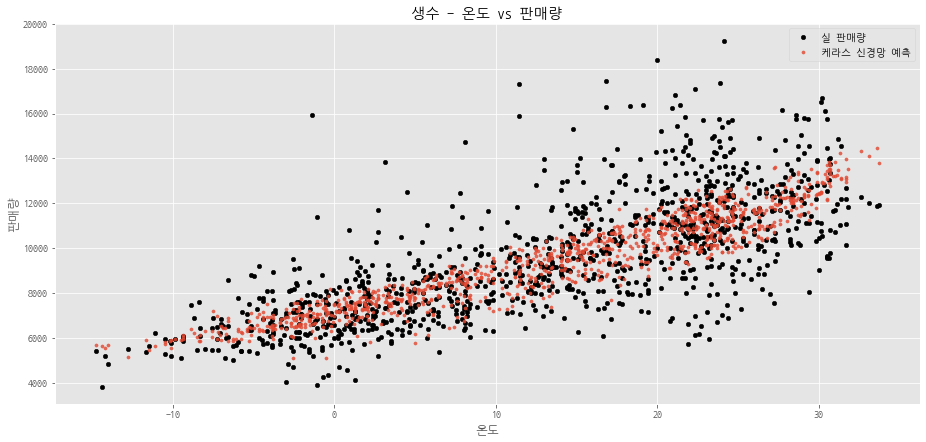

In [26]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_3','aircon',
#                                                     'date','PM10']
n=1
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
# plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )
plt.title('%s - %s vs 판매량' % (item, '온도') )
plt.scatter(Xy.iloc[:,n],result_df.qty, label = '실 판매량', s=20, c='k')
plt.scatter(Xy.iloc[:,n],result_df.keras_qty, label = '케라스 신경망 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.rf_qty, label = 'RandomForest 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.xgb_qty, label = 'XGBoosting 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.lin_qty, label = '선형 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ridge_qty, label = 'Ridge 예측', alpha=alp, s=dot_size)
# plt.scatter(Xy.iloc[:,n],result_df.ols_qty, label = 'OLS 예측', alpha=alp, s=dot_size)

# X axis
# plt.xlabel('{}'.format(Xy.columns[n]))
plt.xlabel('온도')

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
figure_name = 'D:/project/contest/ppt/picture/%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()

In [27]:
def airconall(x):
    if x[0]==1:
        return '좋음'
    elif x[1]==1:
        return '보통'
    elif x[2]==1:
        return '나쁨'
    elif x[3]==1:
        return '매우나쁨'

Xy['aircon'] =Xy[['공기상태_0','공기상태_1','공기상태_2','공기상태_3']].apply(airconall, axis=1)

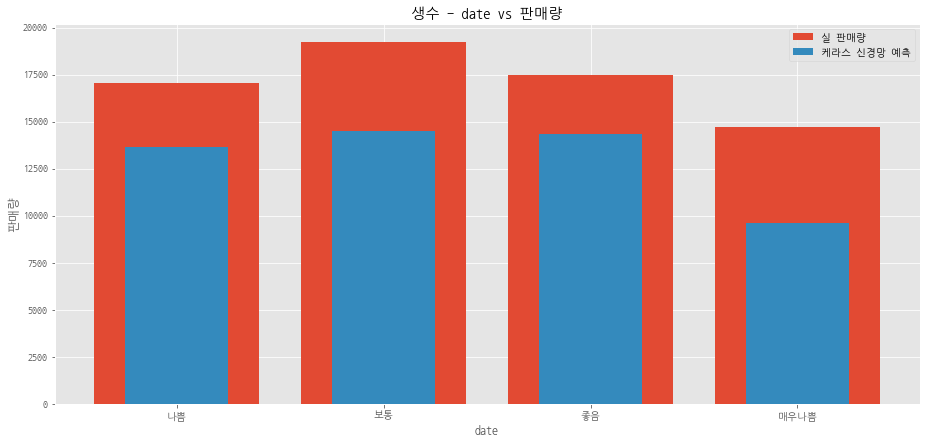

In [28]:
# 독립변수 Xy의 col번호: 0=qty
# ['qty', 'temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not','snow_or_not', 
#                                                   '공기상태_0', '공기상태_1', '공기상태_2','공기상태_2', 'aircon']
# 1~11
n=11
# alpha 값 0~1
alp = 0.8
# scatter plot 점 크기
dot_size = 10

matplotlib.rcParams['font.family'] = 'NanumGothicCoding'
plt.figure(figsize=(15.5,7))
plt.style.use('ggplot')
plt.title('%s - %s vs 판매량' % (item, Xy.columns[n]) )

ind = np.arange(4)
plt.bar(Xy.aircon,result_df.qty, label = '실 판매량')
plt.bar(Xy.aircon,result_df.keras_qty, label = '케라스 신경망 예측',width = 0.5)
# plt.bar(Xy.aircon,result_df.rf_qty, label = 'RandomForest 예측')
# plt.bar(Xy.aircon,result_df.xgb_qty, label = 'XGBoosting 예측')
# plt.bar(Xy.aircon,result_df.lin_qty, label = '선형 예측')
# plt.bar(Xy.aircon,result_df.ridge_qty, label = 'Ridge 예측')
# plt.bar(Xy.aircon,result_df.ols_qty, label = 'OLS 예측')

# X axis
plt.xlabel('{}'.format(Xy.columns[n]))

# y axis
plt.ylabel('판매량')

# 범례
plt.legend()
plt.show()

In [29]:
tt = ['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']
print(tt)

['temp', 'cloud', 'wind', 'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon']


In [30]:
Xy.head(2)
# result_df.head(2)
result_Xy = pd.concat([result_df, Xy[tt]],axis=1)
result_Xy.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_ridge,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon
0,2016-01-01,6269,7583.143066,6158.8,6796.577148,7698.829540,7935.341653,7697.985958,7802.103588,0.209626,...,0.265807,0.227945,0.244553,1.2,7.0,1.6,2.1,0,0,나쁨
1,2016-01-02,6004,8329.503906,6677.0,8462.561523,8419.755933,8638.695495,8419.265652,8639.655610,0.387326,...,0.438823,0.402276,0.438983,5.7,7.8,2.0,3.6,0,0,보통


In [31]:
result_Xy.columns

Index(['date', 'qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 'ridge_qty',
       'lasso_qty', 'ols_qty', 'mape_keras', 'mape_rf', 'mape_xgb', 'mape_lin',
       'mape_ridge', 'mape_lasso', 'mape_ols', 'temp', 'cloud', 'wind',
       'lgt_time', 'rain_or_not', 'snow_or_not', 'aircon'],
      dtype='object')

In [32]:
def tempCat(x):
    if x < -10:
        return 0
    elif x < 0:
        return 1
    elif x < 10:
        return 2
    elif x < 20:
        return 3
    elif x < 30:
        return 4
    else:
        return 5
    
w_seoul['temp_cat'] = w_seoul.temp.apply(tempCat)
XyAndPm10 = pd.merge(result_Xy, w_seoul[['date','temp_cat']], on='date', how='left')
XyAndPm10.head()

,date,qty,keras_qty,rf_qty,xgb_qty,lin_qty,ridge_qty,lasso_qty,ols_qty,mape_keras,...,mape_lasso,mape_ols,temp,cloud,wind,lgt_time,rain_or_not,snow_or_not,aircon,temp_cat
0,2016-01-01,6269,7583.143066,6158.8,6796.577148,7698.829540,7935.341653,7697.985958,7802.103588,0.209626,...,0.227945,0.244553,1.2,7.0,1.6,2.1,0,0,나쁨,2
1,2016-01-02,6004,8329.503906,6677.0,8462.561523,8419.755933,8638.695495,8419.265652,8639.655610,0.387326,...,0.402276,0.438983,5.7,7.8,2.0,3.6,0,0,보통,2
2,2016-01-03,5365,8354.125000,6610.9,8324.194336,8678.543864,8795.452031,8677.549340,8788.553748,0.557153,...,0.617437,0.638127,6.5,7.5,1.8,2.2,0,0,나쁨,2
3,2016-01-04,7022,7318.635254,7189.2,8041.554199,8136.456276,8322.894384,8136.055547,7951.001725,0.042244,...,0.158652,0.132299,2.0,4.4,3.1,8.6,0,0,나쁨,2
4,2016-01-05,6060,6532.521484,6149.9,7072.364746,7236.744448,7566.001832,7236.845715,7076.225168,0.077974,...,0.194199,0.167694,-2.7,3.4,2.3,7.9,0,0,보통,1


In [33]:
p_df = pd.pivot_table(XyAndPm10[['date','qty', 'keras_qty', 'rf_qty', 'xgb_qty', 'lin_qty', 
                                 'ridge_qty','lasso_qty', 'ols_qty', 'temp_cat']],
                     values = ['qty', 'keras_qty', 'rf_qty', 'xgb_qty', 
                               'lin_qty', 'ridge_qty','lasso_qty', 'ols_qty'],
                     index=['temp_cat'],
                     aggfunc = np.sum)
p_df = p_df.iloc[:,[4,0,1,2,3,5,6,7]]
p_df

,qty,keras_qty,lasso_qty,lin_qty,ols_qty,rf_qty,ridge_qty,xgb_qty
temp_cat,,,,,,,,
0,70189,7.361457e+04,6.861306e+04,6.860496e+04,6.950731e+04,72999.1,7.470319e+04,7.460442e+04
1,1079917,1.061578e+06,1.113976e+06,1.113996e+06,1.098802e+06,1117508.6,1.158326e+06,1.121314e+06
2,2000788,1.995456e+06,2.135562e+06,2.135545e+06,2.145857e+06,2114642.1,2.181206e+06,2.103902e+06
3,2702812,2.596664e+06,2.803385e+06,2.803306e+06,2.807729e+06,2887023.8,2.802332e+06,2.850913e+06
4,4154431,4.039343e+06,4.315128e+06,4.315133e+06,4.329335e+06,4313755.8,4.256282e+06,4.289589e+06
5,489009,5.302019e+05,5.552365e+05,5.552487e+05,5.340540e+05,545837.5,5.408555e+05,5.418446e+05


In [37]:
# 8개 판매량

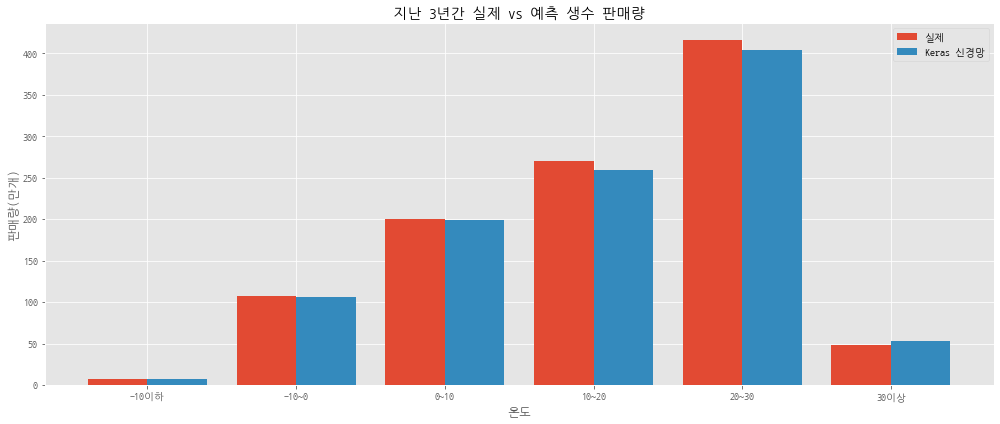

In [34]:
# 사이즈 변경 
rcParams['figure.figsize'] = 14, 6

# 공기상태 길이 만큼 x축 칸 생성
ind = np.arange(len(p_df.index))
# 바의 너비 설정
width = 0.4

# 한 그래프에 여러 값의 바그래프를 넣기 위한 그래프 객체 생성
fig, ax = plt.subplots()

# 각각의 그래프 생성
rects1 = ax.bar(ind - width/2, p_df.qty/10000, width, label = '실제')
rects2 = ax.bar(ind + width/2, p_df.keras_qty/10000, width, label = 'Keras 신경망')
# rects3 = ax.bar(ind - width*2, p_df.lasso_qty, width, label = 'Lasso')
# rects4 = ax.bar(ind - width*1, p_df.lin_qty, width, label = 'Linear')
# rects5 = ax.bar(ind + width*0, p_df.ols_qty, width, label = 'OLS')
# rects6 = ax.bar(ind + width*1, p_df.rf_qty, width, label = 'RandomForest')
# rects7 = ax.bar(ind + width*2, p_df.ridge_qty, width, label = 'Ridge')
# rects8 = ax.bar(ind + width*3, p_df.xgb_qty, width, label = 'XGB', color = 'green')

# 제목
ax.set_title('지난 3년간 실제 vs 예측 %s 판매량'%item)

# y축
ax.set_ylabel('판매량(만개)')

# x축
ax.set_xticks(ind)

# x 값 이름
ax.set_xticklabels(('-10이하','-10~0','0~10','10~20','20~30','30이상'))
ax.set_xlabel('온도')

# 범례
ax.legend()

fig.tight_layout()
figure_name = 'D:/project/contest/ppt/picture/실제vs예측_%s_판매량(3년).png'%item
plt.savefig(figure_name)
plt.show()